# Deps

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
def CountVocab(ds):
    return len(set([p for o in ds.items for p in o]))

In [4]:
def VocabTransfered(path_dict,itos_new):
    old_itos = pickle.load(open(path_dict, 'rb'))
    vocab = [];
    n_vocab_trns = 0
    for i,w in enumerate(itos_new):       
        if w in old_itos:
            vocab.append(w)
            n_vocab_trns +=1
    return n_vocab_trns, len(itos_new), vocab;

In [5]:
def SampleTexts(df,max_tokens = 100000000):
    lens = np.array(df.apply(lambda x : len(re.findall(r'\b',x.text))/2,axis=1))
    n_tokens = np.sum(lens)
    if n_tokens <= max_tokens:
        return range(0,df.shape[0]), n_tokens
    #if np.sum(lens) > max_tokens:
    iDec = (-lens).argsort()
    cumSum = np.cumsum(lens[iDec])
    iCut = np.argmax(cumSum>max_tokens)
    return iDec[:iCut], cumSum[iCut-1]

In [6]:
def calc_f1(cm):
    "Calculate the various f1 scores using the confustion matrix"
    n_rows, n_cols = cm.shape
    if(n_rows != n_cols):
        return 0
    f1 = np.zeros(n_rows)
    tp = 0
    for i in range(0,3):
        tp += cm[i,i]
        col_sum = np.sum(cm[:,i])
        if col_sum == 0 or cm[i,i] == 0:
            f1[i] = 0
        else:
            pr = cm[i,i]/col_sum
            rc = cm[i,i]/(np.sum(cm[i,:]))
            f1[i] = (2*pr*rc)/(pr+rc)

    f1_macro = np.mean(f1)
    f1_micro = tp/np.sum(cm)
    f1_weighted = np.sum(cm,axis=1)@f1/np.sum(cm)
    return f1_micro,f1_macro,f1_weighted,f1

In [7]:
def calc_f1_batch(x,y):
    "Calculate the various f1 scores as using prediction and target"
    n_classes = 3
    tp = np.zeros(n_classes)
    tp_plus_fp = np.zeros(n_classes)
    tp_plus_fn = np.zeros(n_classes)
    f1 = np.zeros(n_classes)

    # on_batch_end - uses += to work with batches as metric
    preds = x.argmax(1)
    targets = y
    for i in range(0,n_classes):
        tp[i] += ((preds==i) * (targets==i)).float().sum()
        tp_plus_fp[i] += (preds==i).float().sum()
        tp_plus_fn[i] += (targets==i).float().sum()

    # on_epoch_end
    for i in range(0,n_classes):
        if tp[i] == 0 or tp_plus_fp[i] == 0:
            f1[i]  = 0
        else:
            pr = tp[i]/tp_plus_fp[i]
            rc = tp[i]/tp_plus_fn[i]
            f1[i] = (2*pr*rc)/(pr+rc)

    n = tp_plus_fn.sum()
    f1_macro = np.mean(f1)
    f1_micro = tp.sum()/n
    f1_weighted = tp_plus_fn@f1/n
    return torch.from_numpy(np.array(f1_weighted))

class f1(Callback):
    "Calculate f1 score in a callback"
    def __init__(self, n_classes, method = 'f1_micro'):
        self.n_classes = n_classes
        self.tp = np.zeros(n_classes)
        self.tp_plus_fp = np.zeros(n_classes)
        self.tp_plus_fn = np.zeros(n_classes)
        self.f1 = np.zeros(n_classes)
        self.method = method
          
    def on_epoch_begin(self, **kwargs):
        self.tp.fill(0)
        self.tp_plus_fp.fill(0)
        self.tp_plus_fn.fill(0)
        self.f1.fill(0)
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        preds = last_output.argmax(1)
        targets = last_target
        for i in range(0,self.n_classes):
            self.tp[i] += ((preds==i) * (targets==i)).float().sum()
            self.tp_plus_fp[i] += (preds==i).float().sum()
            self.tp_plus_fn[i] += (targets==i).float().sum()

    def on_epoch_end(self, **kwargs):     
        for i in range(0,self.n_classes):
            if self.tp[i] == 0 or self.tp_plus_fp[i] == 0:
                self.f1[i]  = 0
            else:
                pr = self.tp[i]/self.tp_plus_fp[i]
                rc = self.tp[i]/self.tp_plus_fn[i]
                self.f1[i] = (2*pr*rc)/(pr+rc)
                
        if self.method == 'f1_macro':
            self.metric = np.mean(self.f1)
        else:
            n = self.tp_plus_fn.sum()
            if self.method == 'f1_micro':
                self.metric = self.tp.sum()/n
            elif self.method == 'f1_weighted':        
                self.metric = self.tp_plus_fn@self.f1/n

In [8]:
class Results():
    # class containing mutable data type to return results from a callback
    def __init__(self):
        self.vals = []
        self.epoch = []
        
    def add(self,epoch,val):
        self.epoch.append(epoch)
        self.vals.append(val)
        
class RecordTestImprovement(TrackerCallback):
    "A `TrackerCallback` that calculates the test metric every time the validation metric improves."
    def __init__(self, learn:Learner, results:Results, data_test, monitor:str='val_loss', mode:str='auto', every:str='improvement'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.results = results
        self.every = every
        self.data_test = data_test

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        current = self.get_monitor_value()
        if current is not None and self.operator(current, self.best):
            previous_data = self.learn.data
            self.learn.data = self.data_test
            x,y = self.learn.get_preds(pbar = self.learn.recorder.pbar);
            f1 = calc_f1_batch(x,y)
            self.learn.data = previous_data 
            self.results.add(epoch,f1)
            self.best = current

In [9]:
import ntpath
txt_proc = [TokenizeProcessor(tokenizer=Tokenizer(lang='el') ),NumericalizeProcessor()]
def cross_val(path,data_dir,source_txt,n_folds,lrs,n_cycles,bs,pretrained_fnames=None,ft_lm=False,stratified=True,ft_lm_epochs=100,rnd_seed=1024):
    """Simulate results from the paper by performing cross validation.
    1) Without pretrained language model pretrained_fnames=None
    2) With pretrained language model pretrained_fnames = [learn.save(THIS_FILE_NAME),pickle.dump(data_lm.vocab.itos, THIS_FILE_NAME)]
    3) UlmFit pretrained_fnames and ft_lm = True
    """
    if n_folds < 3:
        return
    ident = ntpath.basename(source_txt)
    lm_encoder_file = 'cv_enc_' + ident
    vocab = None;
    df = pd.read_csv(path/f'{data_dir}/{source_txt}');
    n_recs = len(df.index)
    n_classes = df.iloc[:,2].value_counts().count()
    
    vocab_sizes = np.zeros(n_folds,'float')
    vocab_trns_val = np.zeros(n_folds,'float')
    vocab_trns_test = np.zeros(n_folds,'float')
    vocab_lm_trns = np.zeros(n_folds,'float')
    f1_val = np.zeros([n_folds,n_classes])
    val_metrics = []
    val_losses = []
    f1_test = np.zeros([n_folds,n_classes])
    test_metrics = []
        
    if stratified:
        df_list = []
        for i in range(0,n_folds):
            df_sample = df.groupby('Polarity1', group_keys=False).apply(
                lambda x: x.sample(frac=1/(n_folds-i),random_state=rnd_seed))
            df = df.drop(df_sample.index)
            df_list.append(df_sample)
        df = pd.concat(df_list)
        idx = range(0,n_recs)
    else:
        np.random.seed(rnd_seed)
        idx = np.random.permutation(n_recs)
        
    cuts = np.linspace(0,n_recs,n_folds+1,dtype='int')
    for i in range(0,n_folds):
        val_idx = idx[cuts[i]:cuts[i+1]]
        if i == n_folds-1:
            test_idx = idx[cuts[0]:cuts[1]]
        else:
            test_idx = idx[cuts[i+1]:cuts[i+2]]
        trn_idx = np.setdiff1d(range(0,n_recs), np.concatenate((val_idx,test_idx)))
            
        if pretrained_fnames != None:            
            data_class_lm = (TextList.from_df(df,path_class/data_dir,cols=1,processor=txt_proc)
                .split_by_idxs(trn_idx,val_idx)
                .label_for_lm()
                .databunch(bs=bs,num_workers=0))
            vocab = data_class_lm.vocab
            vocab_lm_trns[i],_,_= VocabTransfered(str(pretrained_fnames[1]) + '.pkl',vocab.itos)

            learn = language_model_learner(data_class_lm, AWD_LSTM,pretrained_fnames=pretrained_fnames, drop_mult=0.3)
            if ft_lm:
                # Fine tune the given language model
                learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
                learn.unfreeze()
                learn.fit_one_cycle(ft_lm_epochs, 1e-3, moms=(0.8,0.7),callbacks=[ShowGraph(learn), 
                    SaveModelCallback(learn,monitor='accuracy',mode='max',name='cv_bestmodel_lm_ft_' + ident)])
                learn.load('cv_bestmodel_lm_ft_' + ident)
                
            learn.save_encoder(lm_encoder_file)            
        
        data_class = (TextList.from_df(df,path_class/data_dir,cols=1,vocab=vocab,processor=txt_proc)
            .split_by_idxs(trn_idx,val_idx)
            .label_from_df(cols=2)
            .databunch(bs=bs,num_workers=0))
        vocab_sizes[i] = len(data_class.vocab.itos)
        vocab_trns_val[i] = CountVocab(data_class.valid_ds)
        data_class_val_is_test = (TextList.from_df(df,path_class/data_dir,cols=1,vocab=vocab,processor=txt_proc)
            .split_by_idxs(trn_idx,test_idx)
            .label_from_df(cols=2)
            .databunch(bs=bs,num_workers=0))
        vocab_trns_test[i] = CountVocab(data_class.valid_ds)
        
        learn = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5,
                                        metrics=[accuracy,f1(3,'f1_macro'),f1(3,'f1_micro'),f1(3,'f1_weighted')])
        if pretrained_fnames != None: 
            learn.load_encoder(lm_encoder_file)
        learn.freeze()
        learn.fit_one_cycle(n_cycles[0], lrs[0], moms=(0.8,0.7))
        learn.freeze_to(-2)
        learn.fit_one_cycle(n_cycles[1], slice(lrs[1]/(2.6**4),lrs[1]), moms=(0.8,0.7))
        learn.freeze_to(-3)
        learn.fit_one_cycle(n_cycles[2], slice(lrs[2]/(2.6**4),lrs[2]), moms=(0.8,0.7))
        learn.unfreeze()
        test_results = Results()
        learn.fit_one_cycle(n_cycles[3], slice(lrs[3]/(2.6**4),lrs[3]), moms=(0.8,0.7),
                            callbacks=[ShowGraph(learn), 
                                       SaveModelCallback(learn,monitor='f1',mode='max',name='cv_bestmodel_'+ str(i)),        
                                       RecordTestImprovement(learn,test_results,data_class_val_is_test,monitor='f1',mode='max')])
        learn.load('cv_bestmodel_'+ str(i));
        
        interp = ClassificationInterpretation.from_learner(learn)
        _,_,_,f1_val[i,:] = calc_f1(interp.confusion_matrix())
        
        # get results directly from recorded metrics
        val_metrics.append(learn.recorder.metrics) 
        val_losses.append(learn.recorder.val_losses)
        test_metrics.append(test_results)

        learn.data = data_class_val_is_test
        interp = ClassificationInterpretation.from_learner(learn)
        _,_,_,f1_test[i,:] = calc_f1(interp.confusion_matrix())
    return ((vocab_sizes,vocab_lm_trns,vocab_trns_val,vocab_trns_test),(f1_val),(f1_test),(val_metrics,test_metrics,val_losses))

In [10]:
def extract_test_res(max_epoch,test_res):
    n_folds = len(test_res)
    extracted = np.zeros([n_folds,max_epoch])
    for idx, result in enumerate(test_res):    
        epochs = np.array(result.epoch)
        indices = np.zeros(max_epoch).astype(np.int)
        if len(epochs) > 1:
            indices[epochs[1:]-1] = 1  
        vals = np.array(result.vals)    
        extracted[idx,:] = vals[indices.cumsum()]
    return extracted

In [11]:
def get_progress(f1_res):
    max_epoch = len(f1_res[3][0][0]);
    f1_test = extract_test_res(max_epoch,f1_res[3][1])
    f1_val = np.array([[epoch_res[-1] for epoch_res in fold_res] for fold_res in f1_res[3][0]])
    f1_val_loss = np.array([[epoch_res for epoch_res in fold_res] for fold_res in f1_res[3][2]])
    i_last_increase = f1_val.mean(axis=0).argmax()
    return f1_test, f1_val, f1_val_loss, i_last_increase

In [12]:
path_class = Path('/home/jupyter/tutorials/')
source_txt_class='GRGE_sentiment.csv'
path_lang_model = Path('/home/jupyter/tutorials/')
data_dir = 'data'
wiki_txt_file = 'el_wiki_df_all.csv'

# Greek Election Tweets Sentiment (<a href="https://link.springer.com/content/pdf/10.1007%2Fs10579-018-9420-4.pdf">tsakalidis2018</a>)

Data <a href="http://mklab.iti.gr/resources/tsakalidis2017building.zip">source</a>

In [12]:
paper_class_counts = pd.Series({'Neutral' : 979, 'Negative' : 582, 'Positive' : 79})
paper_baseline = 0.4463
sota = 0.8066

In [13]:
txt_proc = [TokenizeProcessor(tokenizer=Tokenizer(lang='el') ),NumericalizeProcessor()]

## Process data

In [13]:
bs = 128
proc_data = True
stratified = True
rnd_seed = 1024

In [38]:
# process all the data in the begining - the vocab is small because of the size of the data set, therefore it seems 
# to be important to use the same training indices for the lm and classification model as this results in the largest 
# vocab for classification.
if proc_data:
    # split the classifcation data into train, test and validation sets and choose the test set
    i_test_fold = 0
    n_folds = 10
    df = pd.read_csv(path_class/f'{data_dir}/{source_txt_class}');
    n_recs = len(df.index)
    
    if stratified:
        df_list = []
        for i in range(0,n_folds):
            df_sample = df.groupby('Polarity1', group_keys=False).apply(
                lambda x: x.sample(frac=1/(n_folds-i),random_state=rnd_seed))
            df = df.drop(df_sample.index)
            df_list.append(df_sample)
        df = pd.concat(df_list)
        idx = range(0,n_recs)
    else:
        np.random.seed(rnd_seed)
        idx = np.random.permutation(n_recs)
    
    cuts = np.linspace(0,n_recs,n_folds+1,dtype='int')
    test_idx = idx[cuts[i_test_fold]:cuts[i_test_fold+1]]
    if i_test_fold == n_folds-1:
        valid_idx = idx[cuts[0]:cuts[1]]
    else:
        valid_idx = idx[cuts[i_test_fold+1]:cuts[i_test_fold+2]]
    train_idx = np.setdiff1d(range(0,n_recs), np.concatenate((valid_idx,test_idx)))

    data_class_lm = (TextList.from_df(df, path_class,cols=1,processor = txt_proc)
        .split_by_idxs(train_idx,valid_idx)
        .label_for_lm()
        .databunch(bs=bs))    
    data_class_lm.save('tmp_data_lm'+ source_txt_class)
    
    data_class = (TextList.from_df(df,path_class,cols=1,vocab=data_class_lm.train_ds.vocab,processor = txt_proc)
        .split_by_idxs(train_idx,valid_idx)
        .label_from_df(cols=2)
        .databunch(bs=bs))
    #print(f'Vocab size for classification model:{len(data_class.vocab.itos)}')
    data_class.save('tmp_data_class'+ source_txt_class)

    data_class_val_is_test = (TextList.from_df(df, path_class,cols=1,vocab=data_class_lm.train_ds.vocab,processor = txt_proc)
        .split_by_idxs(train_idx,test_idx)
        .label_from_df(cols=2)
        .databunch(bs=bs))
    data_class_val_is_test.save('tmp_data_class_test'+ source_txt_class)
    
else:
    data_class_lm = TextLMDataBunch.load(path_class, 'tmp_data_lm'+ source_txt_class, bs=bs)
    data_class = TextClasDataBunch.load(path_class, 'tmp_data_class'+ source_txt_class, bs=bs)
    data_class_val_is_test = TextClasDataBunch.load(path_class, 'tmp_data_class_test'+ source_txt_class, bs=bs)
    #print(f'Vocab size for language model:{len(data_class_lm.vocab.itos)}')
    #print(f'Vocab size for classification model:{len(data_class.vocab.itos)}')
    
print(f'Vocab size:{len(data_class_lm.vocab.itos)}')
print(f'Vocab present in val:{CountVocab(data_class_lm.valid_ds)}')
print(f'Vocab present in test:{CountVocab(data_class_val_is_test.valid_ds)}')

Vocab size:784
Vocab present in val:368
Vocab present in test:353


## Quick sanity checks

Confirm class distributions and metric by calculating the weighted f1 score by just using the majority class and comparing to table 4 in the paper

In [18]:
df = pd.read_csv(path_class/f'data/{source_txt_class}');
class_counts = np.array(df.iloc[:,2].value_counts())
cm_mc = np.zeros([class_counts.size,class_counts.size])
mc = class_counts.argmax()
cm_mc[:,mc] = class_counts
f1_micro,f1_macro,f1_weighted,_= calc_f1(cm_mc)
print(f'f1 scores using majority class\nMicro: {f1_micro}\nMacro: {f1_macro}\nWeighted: {f1_weighted} <- mc from paper')

f1 scores using majority class
Micro: 0.5969512195121951
Macro: 0.24920453099147255
Weighted: 0.4462888460499725 <- mc from paper


In [19]:
if(df.Polarity1.value_counts().equals(paper_class_counts) and round(f1_weighted,4) ==  paper_baseline):
    print("Basic test passed")
else:
    print("Something has gone wrong")

Basic test passed


## Train classifier without pre-trained language model

To confirm that ULMFiT shows an improvement train the classifier without a pretrained language model

### Train

In [116]:
learn = text_classifier_learner(data_class, AWD_LSTM,drop_mult=0.5,
                                metrics=[accuracy,f1(3,'f1_macro'),f1(3,'f1_micro'),f1(3,'f1_weighted')])
learn.freeze()

In [117]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


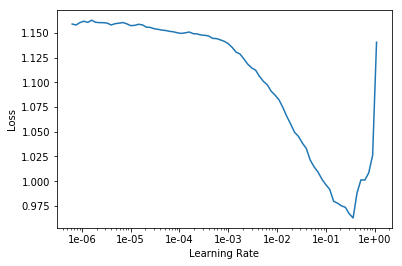

In [118]:
learn.recorder.plot()

In [119]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.938183,0.943121,0.597561,0.249364,0.597561,0.447030,00:01


In [120]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.756421,0.863508,0.597561,0.249364,0.597561,0.447030,00:01


In [121]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.694380,0.823837,0.597561,0.249364,0.597561,0.447030,00:01


epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.653917,0.836706,0.597561,0.249364,0.597561,0.447030,00:01
2,0.647456,0.809734,0.597561,0.249364,0.597561,0.447030,00:01
3,0.637066,0.768810,0.597561,0.249364,0.597561,0.447030,00:01
4,0.637598,0.713172,0.719512,0.438889,0.719512,0.664837,00:01
5,0.634146,0.652290,0.804878,0.533186,0.804878,0.776640,00:01
6,0.631545,0.611878,0.804878,0.533186,0.804878,0.776640,00:01
7,0.630204,0.581447,0.798781,0.529000,0.798780,0.770946,00:01
8,0.626823,0.570962,0.798781,0.529000,0.798780,0.770946,00:01
9,0.625071,0.567511,0.798781,0.529000,0.798780,0.770946,00:01
10,0.623026,0.567581,0.798781,0.529000,0.798780,0.770946,00:01


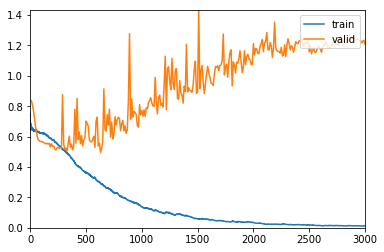

Better model found at epoch 1 with f1 value: 0.447030348166077.
Better model found at epoch 4 with f1 value: 0.6648373983739837.
Better model found at epoch 5 with f1 value: 0.7766402539921703.
Better model found at epoch 12 with f1 value: 0.7777827050997783.
Better model found at epoch 15 with f1 value: 0.779810298102981.
Better model found at epoch 18 with f1 value: 0.7845511915040485.
Better model found at epoch 19 with f1 value: 0.786413850849472.
Better model found at epoch 22 with f1 value: 0.7987089106771467.
Better model found at epoch 25 with f1 value: 0.7994522870067452.
Better model found at epoch 39 with f1 value: 0.8042765485681935.
Better model found at epoch 48 with f1 value: 0.8046677880571909.
Better model found at epoch 53 with f1 value: 0.8210727842080947.
Better model found at epoch 63 with f1 value: 0.8312356017113395.
Better model found at epoch 64 with f1 value: 0.8354442843444523.
Better model found at epoch 86 with f1 value: 0.8398614242444945.
Better model fou

In [111]:
# try to overfit
learn.unfreeze()
learn.fit_one_cycle(300, slice(2.5e-3/(2.6**4),2.5e-3), moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='f1',mode='max',name='bestmodel_sent_base')])

### Examine Results

#### Results on validation set

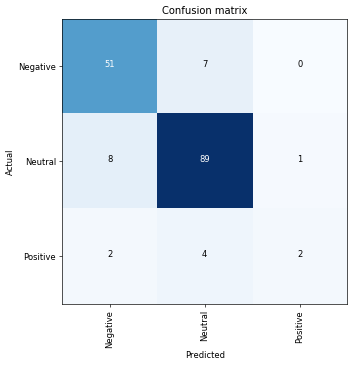

In [123]:
learn.load('bestmodel_sent_base');
learn.data = data_class
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [124]:
_,_,f1_macro_weighted,_ = calc_f1(interp.confusion_matrix())
print(f'Macro weighted f1 on best valid set without pre-trained language model: {f1_macro_weighted}')

Macro weighted f1 on best valid set without finetuning the language model: 0.858075528807236


#### Results on test set

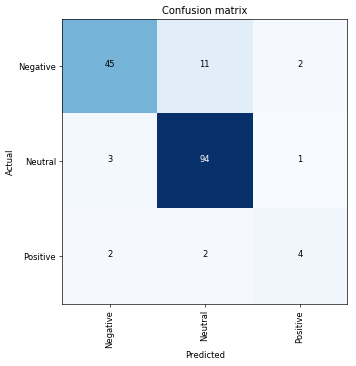

In [125]:
learn.load('bestmodel_sent_base');
learn.data = data_class_val_is_test
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [126]:
_,_,f1_macro_weighted,_ = calc_f1(interp.confusion_matrix())
print(f'Macro weighted f1 on best test set without pre-trained language model: {f1_macro_weighted}')

Macro weighted f1 on best test set without finetuning the language model: 0.8687388459250448


### Cross Validation

The results in the paper use the mean of the weighted f1 score over 10 folds - examine the effect of choosing the best model from a greater and greater number of training cycles

In [166]:
n_folds = 10
lr = 2e-2
lrs = np.array([lr,lr/2,lr/4,lr/20])
n_cycles = np.array([1,1,1,300])
bs=128
stratified = True

In [167]:
pretrained_fnames = None;
ft_lm = False
f1_res = cross_val(path_class,data_dir,source_txt_class,n_folds,lrs,n_cycles,bs,pretrained_fnames,ft_lm)

In [168]:
max_epoch = len(f1_res[3][0][0]);
f1_test = extract_test_res(max_epoch,f1_res[3][1])
f1_val = np.array([[epoch_res[-1] for epoch_res in fold_res] for fold_res in f1_res[3][0]])
f1_val_loss = np.array([[epoch_res for epoch_res in fold_res] for fold_res in f1_res[3][2]])
i_last_increase = f1_val.mean(axis=0).argmax()
print(f'Highest mean f1 micro on validation set: {f1_val.mean(axis=0)[i_last_increase]}')
print(f'Mean f1 micro on Test set with model from best val set: {f1_test.mean(axis=0)[i_last_increase]}')
print(f'Highest mean f1 micro on Test set: {f1_test.mean(axis=0).max()}')

Highest mean f1 micro on validation set: 0.8341226644626178
Mean f1 micro on Test set with model from best val set: 0.815901138229474
Highest mean f1 micro on Test set: 0.8202824078853018


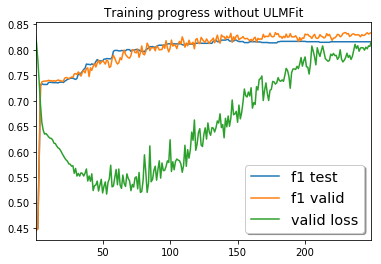

In [169]:
ax = plt.subplot()
ax.plot(f1_test.mean(axis=0),label='f1 test');
ax.plot(f1_val.mean(axis=0),label='f1 valid');
ax.plot(f1_val_loss.mean(axis=0),label='valid loss')
ax.set_xlim(1, i_last_increase);
ax.legend(loc='lower right', shadow=True, fontsize='x-large');
ax.set_title('Training progress without ULMFit');

In [170]:
import pickle
with open('base_progress.pkl', 'wb') as f:
    pickle.dump(f1_res, f)

## Perform classification using the wiki language model without fine tuning

### Save wiki103 encoder

In [48]:
learn = language_model_learner(data_class_lm,AWD_LSTM, pretrained_fnames=[path_lang_model/f'models/bestmodel_lm5_{wiki_txt_file}',path_lang_model/f'data/dict_{wiki_txt_file}'], drop_mult=0.3)
learn.save_encoder('wk103_enc')

### Train

In [127]:
learn = text_classifier_learner(data_class, AWD_LSTM,drop_mult=0.5,
                                metrics=[accuracy,f1(3,'f1_macro'),f1(3,'f1_micro'),f1(3,'f1_weighted')])
learn.load_encoder('wk103_enc')
learn.freeze()

In [128]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


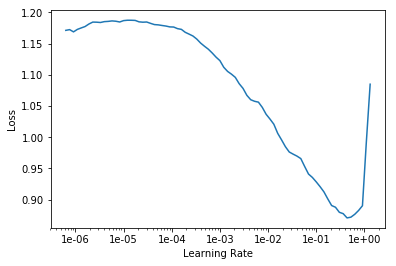

In [129]:
learn.recorder.plot()

In [130]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.816401,0.853368,0.597561,0.249364,0.597561,0.447030,00:01


In [131]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.644973,0.649833,0.725610,0.449562,0.725610,0.676624,00:01


In [132]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.599460,0.560332,0.786585,0.516023,0.786585,0.755618,00:01


epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.567890,0.515185,0.810976,0.538751,0.810976,0.783499,00:01
2,0.551770,0.495258,0.817073,0.544242,0.817073,0.790288,00:01
3,0.546366,0.489434,0.817073,0.545422,0.817073,0.791255,00:03
4,0.547546,0.486383,0.817073,0.545422,0.817073,0.791255,00:01
5,0.543039,0.482704,0.817073,0.545422,0.817073,0.791255,00:01
6,0.546070,0.481140,0.817073,0.544286,0.817073,0.791029,00:01
7,0.545495,0.483373,0.817073,0.545422,0.817073,0.791255,00:01
8,0.543967,0.478014,0.810976,0.540123,0.810976,0.785343,00:01
9,0.542192,0.476147,0.810976,0.540123,0.810976,0.785343,00:01
10,0.541828,0.478346,0.817073,0.545422,0.817073,0.791255,00:01


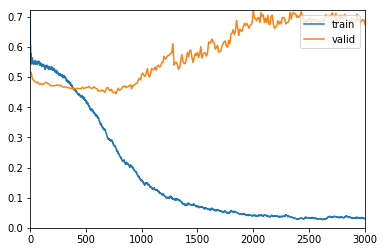

Better model found at epoch 1 with f1 value: 0.7834988222362684.
Better model found at epoch 2 with f1 value: 0.7902882483370287.
Better model found at epoch 3 with f1 value: 0.7912547878851698.
Better model found at epoch 24 with f1 value: 0.7921443958029323.
Better model found at epoch 26 with f1 value: 0.7987089106771467.
Better model found at epoch 29 with f1 value: 0.8052178176516378.
Better model found at epoch 41 with f1 value: 0.8070557491289198.
Better model found at epoch 43 with f1 value: 0.8133261594255035.
Better model found at epoch 46 with f1 value: 0.8258010521281683.
Better model found at epoch 61 with f1 value: 0.8391862294582028.
Better model found at epoch 62 with f1 value: 0.845364919166433.
Better model found at epoch 65 with f1 value: 0.8566892055059165.
Better model found at epoch 69 with f1 value: 0.857027697395618.
Better model found at epoch 77 with f1 value: 0.8579563985510628.
Better model found at epoch 78 with f1 value: 0.8637911004984173.
Better model fo

In [88]:
learn.unfreeze()
learn.fit_one_cycle(300, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='f1',mode='max',name='bestmodel_sent_lm_wk103')])

### Examine Results

#### Result on validation set

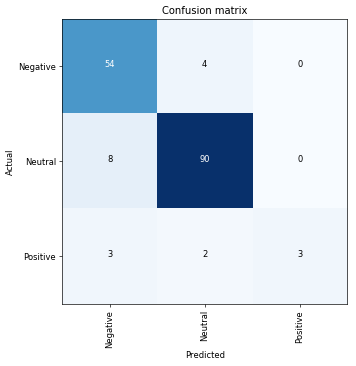

In [89]:
learn.load('bestmodel_sent_lm_wk103');
learn.data = data_class
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [91]:
_,_,f1_macro_weighted,_ = calc_f1(interp.confusion_matrix())
print(f'Macro weighted f1 on best valid set without finetuning the language model: {f1_macro_weighted}')

Macro weighted f1 on best valid set without finetuning the language model: 0.8915750041675333


#### Result on test set

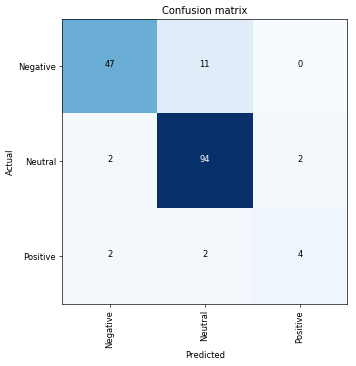

In [92]:
learn.load('bestmodel_sent_lm_wk103');
learn.data = data_class_val_is_test
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [93]:
_,_,f1_macro_weighted,_ = calc_f1(interp.confusion_matrix())
print(f'Macro weighted f1 on test set without finetuning the language model: {f1_macro_weighted}')

Macro weighted f1 on test set without finetuning the language model: 0.8808716337011533


### Cross Validation

In [171]:
n_folds = 10
lr = 2e-2
lrs = np.array([lr,lr/2,lr/4,lr/20])
n_cycles = np.array([1,1,1,300])
bs=128
stratified = True

In [172]:
pretrained_fnames = [path_lang_model/f'models/bestmodel_lm5_{wiki_txt_file}',path_lang_model/f'data/dict_{wiki_txt_file}']
ft_lm = False
f1_res = cross_val(path_class,data_dir,source_txt_class,n_folds,lrs,n_cycles,bs,pretrained_fnames,ft_lm,stratified)

In [173]:
max_epoch = len(f1_res[3][0][0]);
f1_test = extract_test_res(max_epoch,f1_res[3][1])
f1_val = np.array([[epoch_res[-1] for epoch_res in fold_res] for fold_res in f1_res[3][0]])
f1_val_loss = np.array([[epoch_res for epoch_res in fold_res] for fold_res in f1_res[3][2]])
i_last_increase = f1_val.mean(axis=0).argmax()
print(f'Highest mean f1 micro on validation set: {f1_val.mean(axis=0)[i_last_increase]}')
print(f'Mean f1 micro on Test set with model from best val set: {f1_test.mean(axis=0)[i_last_increase]}')
print(f'Highest mean f1 micro on Test set: {f1_test.mean(axis=0).max()}')

Highest mean f1 micro on validation set: 0.8400441155587594
Mean f1 micro on Test set with model from best val set: 0.8408937263758606
Highest mean f1 micro on Test set: 0.8412130967024585


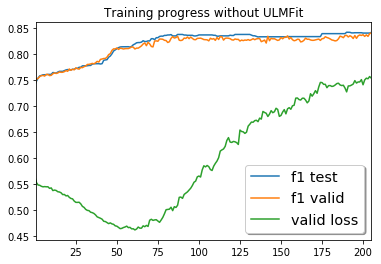

In [174]:
ax = plt.subplot()
ax.plot(f1_test.mean(axis=0),label='f1 test');
ax.plot(f1_val.mean(axis=0),label='f1 valid');
ax.plot(f1_val_loss.mean(axis=0),label='valid loss')
ax.set_xlim(1, i_last_increase);
ax.legend(loc='lower right', shadow=True, fontsize='x-large');
ax.set_title('Training progress without fine tuning the language model');

In [175]:
import pickle
with open('ulm_progress.pkl', 'wb') as f:
    pickle.dump(f1_res, f)

## ULMFiT

### Fine tune the language model using given tweets

In [134]:
learn = language_model_learner(data_class_lm, AWD_LSTM, pretrained_fnames=[path_lang_model/f'models/bestmodel_lm5_{wiki_txt_file}',path_lang_model/f'data/dict_{wiki_txt_file}'], drop_mult=0.3)

In [135]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


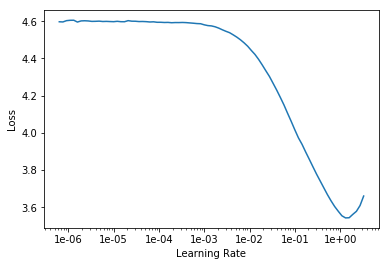

In [136]:
learn.recorder.plot(skip_end=5)

In [137]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,4.492359,4.144363,0.357366,00:00


epoch,train_loss,valid_loss,accuracy,time
1,4.292802,4.064560,0.358036,00:00
2,4.177151,3.970365,0.365848,00:00
3,4.111998,3.875724,0.381027,00:00
4,4.045170,3.775133,0.393638,00:00
5,3.981470,3.652287,0.395424,00:00
6,3.911278,3.493897,0.406473,00:00
7,3.839427,3.365144,0.412835,00:00
8,3.762679,3.244218,0.421875,00:00
9,3.685198,3.144330,0.430357,00:00
10,3.606471,3.061605,0.437612,00:00


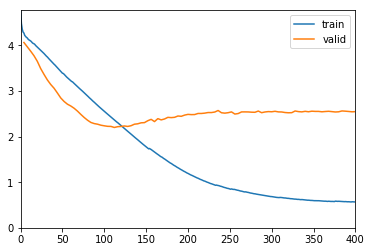

Better model found at epoch 1 with accuracy value: 0.35803571343421936.
Better model found at epoch 2 with accuracy value: 0.36584821343421936.
Better model found at epoch 3 with accuracy value: 0.3810267746448517.
Better model found at epoch 4 with accuracy value: 0.39363840222358704.
Better model found at epoch 5 with accuracy value: 0.39542409777641296.
Better model found at epoch 6 with accuracy value: 0.40647321939468384.
Better model found at epoch 7 with accuracy value: 0.4128348231315613.
Better model found at epoch 8 with accuracy value: 0.421875.
Better model found at epoch 9 with accuracy value: 0.4303571581840515.
Better model found at epoch 10 with accuracy value: 0.4376116096973419.
Better model found at epoch 11 with accuracy value: 0.45066964626312256.
Better model found at epoch 12 with accuracy value: 0.4610491096973419.
Better model found at epoch 13 with accuracy value: 0.4693080484867096.
Better model found at epoch 14 with accuracy value: 0.4738839268684387.
Bette

In [138]:
learn.unfreeze()
learn.fit_one_cycle(100, 1e-3, moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max',name='bestmodel_sent_lm_wk103_ft' )])

In [139]:
learn.load('bestmodel_sent_lm_wk103_ft');

In [140]:
learn.save_encoder('sent_fine_tuned_enc')

### Train the classifier

In [141]:
learn = text_classifier_learner(data_class, AWD_LSTM,drop_mult=0.5,
                                metrics=[accuracy,f1(3,'f1_macro'),f1(3,'f1_micro'),f1(3,'f1_weighted')])
learn.load_encoder('sent_fine_tuned_enc')
learn.freeze()

In [142]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


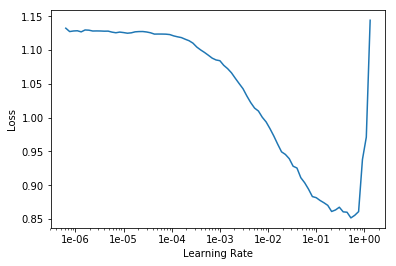

In [143]:
learn.recorder.plot()

In [144]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.788791,0.649496,0.780488,0.510136,0.780488,0.748451,00:01


In [145]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.635268,0.602834,0.810976,0.548546,0.810976,0.790706,00:01


In [146]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.566556,0.511083,0.823171,0.556615,0.823171,0.803505,00:01


epoch,train_loss,valid_loss,accuracy,f1,f1,f1,time
1,0.540968,0.476953,0.823171,0.556615,0.823171,0.803505,00:01
2,0.565553,0.460510,0.823171,0.555920,0.823171,0.803079,00:01
3,0.562606,0.458184,0.823171,0.556615,0.823171,0.803505,00:01
4,0.555123,0.458733,0.823171,0.556615,0.823171,0.803505,00:01
5,0.549631,0.452736,0.823171,0.555920,0.823171,0.803079,00:01
6,0.546702,0.451480,0.817073,0.551111,0.817073,0.796911,00:01
7,0.547519,0.453615,0.817073,0.551857,0.817073,0.797382,00:01
8,0.549614,0.451241,0.823171,0.555179,0.823171,0.802598,00:01
9,0.547969,0.452402,0.817073,0.551857,0.817073,0.797382,00:01
10,0.546355,0.453351,0.817073,0.551857,0.817073,0.797382,00:01


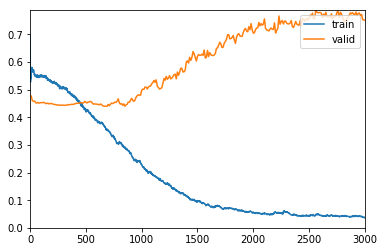

Better model found at epoch 1 with accuracy value: 0.8231707215309143.
Better model found at epoch 17 with accuracy value: 0.8292682766914368.
Better model found at epoch 34 with accuracy value: 0.8353658318519592.
Better model found at epoch 37 with accuracy value: 0.8475610017776489.
Better model found at epoch 44 with accuracy value: 0.8597561120986938.
Better model found at epoch 56 with accuracy value: 0.8658536672592163.
Better model found at epoch 97 with accuracy value: 0.8719512224197388.
Better model found at epoch 124 with accuracy value: 0.8841463327407837.


In [147]:
learn.unfreeze()
learn.fit_one_cycle(300, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7),callbacks=[ShowGraph(learn), SaveModelCallback(learn,monitor='accuracy',mode='max',name='bestmodel_sent_lm_wk103_ft')])

### Examine results

#### Result on validation set

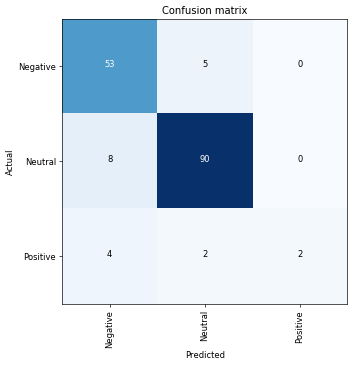

In [155]:
learn.load('bestmodel_sent_lm_wk103_ft');
learn.data = data_class
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [156]:
f1_micro,_,f1_macro_weighted,_ = calc_f1(interp.confusion_matrix())
print(f'Accuracy on best valid set after finetuning the language model: {f1_micro}')
print(f'Macro weighted f1 on best valid set after finetuning the language model: {f1_macro_weighted}')

Accuracy on best valid set after finetuning the language model: 0.8841463414634146
Macro weighted f1 on best valid set after finetuning the language model: 0.8758858432862


#### Result on test set

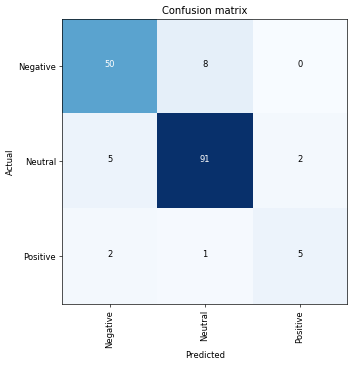

In [157]:
learn.load('bestmodel_sent_lm_wk103_ft');
learn.data = data_class_val_is_test
interp = ClassificationInterpretation.from_learner(learn)
cm = interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

In [158]:
f1_micro,_,f1_macro_weighted,_ = calc_f1(interp.confusion_matrix())
print(f'Accuracy on test set after finetuning the language model: {f1_micro}')
print(f'Macro weighted f1 on test set after finetuning the language model: {f1_macro_weighted}')

Accuracy on test set after finetuning the language model: 0.8902439024390244
Macro weighted f1 on test set after finetuning the language model: 0.8893227074563237


### Cross Validation

In [159]:
n_folds = 10
lr = 2e-2
lrs = np.array([lr,lr/2,lr/4,lr/20])
n_cycles = np.array([1,1,1,300])
bs=128
stratified = True

In [160]:
pretrained_fnames = [path_lang_model/f'models/bestmodel_lm5_{wiki_txt_file}',path_lang_model/f'data/dict_{wiki_txt_file}']
ft_lm = True
f1_res = cross_val(path_class,data_dir,source_txt_class,n_folds,lrs,n_cycles,bs,pretrained_fnames,ft_lm,stratified)

In [161]:
max_epoch = len(f1_res[3][0][0]);
f1_test = extract_test_res(max_epoch,f1_res[3][1])
f1_val = np.array([[epoch_res[-1] for epoch_res in fold_res] for fold_res in f1_res[3][0]])
f1_val_loss = np.array([[epoch_res for epoch_res in fold_res] for fold_res in f1_res[3][2]])
i_last_increase = f1_val.mean(axis=0).argmax()
print(f'Highest mean f1 micro on validation set: {f1_val.mean(axis=0)[i_last_increase]}')
print(f'Mean f1 micro on Test set with model from best val set: {f1_test.mean(axis=0)[i_last_increase]}')
print(f'Highest mean f1 micro on Test set: {f1_test.mean(axis=0).max()}')

Highest mean f1 micro on validation set: 0.8491576570873711
Mean f1 micro on Test set with model from best val set: 0.8334331239135958
Highest mean f1 micro on Test set: 0.8387216034499924


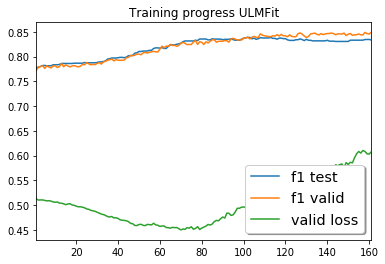

In [163]:
ax = plt.subplot()
ax.plot(f1_test.mean(axis=0),label='f1 test');
ax.plot(f1_val.mean(axis=0),label='f1 valid');
ax.plot(f1_val_loss.mean(axis=0),label='valid loss')
ax.set_xlim(1, i_last_increase);
ax.legend(loc='lower right', shadow=True, fontsize='x-large');
ax.set_title('Training progress ULMFit');

In [164]:
import pickle
with open('ulmfit_progress.pkl', 'wb') as f:
    pickle.dump(f1_res, f)

## Examine learning progress

In [13]:
with open('base_progress.pkl', 'rb') as f:
    base_progress = pickle.load(f)
with open('ulm_progress.pkl', 'rb') as f:
    ulm_progress = pickle.load(f)
with open('ulmfit_progress.pkl', 'rb') as f:
    ulmfit_progress = pickle.load(f)

In [14]:
f1_test_base, f1_val_base, f1_val_loss_base, i_last_increase_base = get_progress(base_progress)
f1_test_ulm, f1_val_ulm, f1_val_loss_ulm, i_last_increase_ulm = get_progress(ulm_progress)
f1_test_ulmfit, f1_val_ulmfit, f1_val_loss_ulmfit, i_last_increase_ulmfit = get_progress(ulmfit_progress)

In [18]:
print('Mean f1 macro on test set with model from best val set')
print(f'Base: {100*f1_test_base.mean(axis=0)[i_last_increase_base]:.2f} %')
print(f'ULM: {100*f1_test_ulm.mean(axis=0)[i_last_increase_ulm]:.2f} %')
print(f'ULMFit: {100*f1_test_ulmfit.mean(axis=0)[i_last_increase_ulmfit]:.2f} %')

Mean f1 macro on test set with model from best val set
Base: 81.59 %
ULM: 84.09 %
ULMFit: 83.34 %


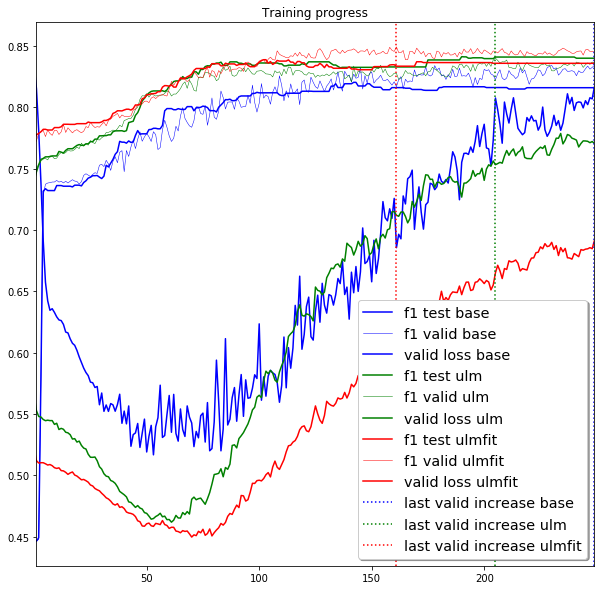

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(f1_test_base.mean(axis=0),'b',label='f1 test base');
ax.plot(f1_val_base.mean(axis=0),'b',label='f1 valid base',linewidth=0.5);
ax.plot(f1_val_loss_base.mean(axis=0),'b',label='valid loss base')
ax.plot(f1_test_ulm.mean(axis=0),'g',label='f1 test ulm');
ax.plot(f1_val_ulm.mean(axis=0),'g',label='f1 valid ulm',linewidth=0.5);
ax.plot(f1_val_loss_ulm.mean(axis=0),'g',label='valid loss ulm')
ax.plot(f1_test_ulmfit.mean(axis=0),'r',label='f1 test ulmfit');
ax.plot(f1_val_ulmfit.mean(axis=0),'r',label='f1 valid ulmfit',linewidth=0.5);
ax.plot(f1_val_loss_ulmfit.mean(axis=0),'r',label='valid loss ulmfit')
ax.axvline(x=i_last_increase_base,linestyle=':',color='b',label='last valid increase base')
ax.axvline(x=i_last_increase_ulm,linestyle=':',color='g',label='last valid increase ulm')
ax.axvline(x=i_last_increase_ulmfit,linestyle=':',color='r',label='last valid increase ulmfit')
ax.set_xlim(1, np.max([i_last_increase_base,i_last_increase_ulm,i_last_increase_ulmfit]));
ax.legend(loc='lower right', shadow=True, fontsize='x-large');
ax.set_title('Training progress');

In [38]:
table_dict = {'': ['SOTA','Base','ULM','ULMFit'],
              'f1 micro %': [80.66, 
                           f1_test_base.mean(axis=0)[i_last_increase_base]*100, 
                           f1_test_ulm.mean(axis=0)[i_last_increase_ulm]*100, 
                           f1_test_ulmfit.mean(axis=0)[i_last_increase_ulmfit]*100]}
pd.DataFrame(data=table_dict).round(2).style.hide_index()

,f1 micro %
SOTA,80.66
Base,81.59
ULM,84.09
ULMFit,83.34
